# K2 C16 M67 lightcurve search

In [1]:
import lightkurve

In [2]:
lightkurve.__version__

'1.0b26.dev'

In [3]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The M67 data is stored as 50 x 50 pixel blocks.  There's apparently no way to figure out which source is in which block!  Whyyyy?   
Let's just manually reverse engineer the pointing.


We'll first identify the list of Custom Aperture IDs that targeted M67.  These Custom Aperture IDs resemble per-target EPIC ids, except that their first three numbers are less than 201.  We can retrieve this list from the K2 website.

We'll then identify a way to derive the cone of sky that each 50 x 50 block observed.

In [4]:
df_targs = pd.read_csv('https://keplerscience.arc.nasa.gov/data/campaigns/c16/K2Campaign16targets.csv')

In [5]:
df_targs.columns

Index(['EPIC ID', ' RA (J2000) [deg]', ' Dec (J2000) [deg]', ' magnitude',
       ' Investigation IDs'],
      dtype='object')

In [6]:
M67_ids = df_targs[' Investigation IDs'].str.contains('M67')

In [7]:
M67_ids.sum()

360

In [8]:
df_M67 = df_targs[M67_ids].reset_index(drop=True)

In [9]:
df_M67.tail()

,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],magnitude,Investigation IDs
355,200200722,,,,GO16064|GO16069|M67
356,200200723,,,,GO16064|GO16069|M67
357,200200724,,,,GO16064|GO16069|M67
358,200200725,,,,GO16064|GO16069|M67
359,200200726,,,,GO16064|GO16069|M67


In [10]:
df_M67['EPIC ID'].values[-5:]

array([200200722, 200200723, 200200724, 200200725, 200200726])

In [11]:
tpf = lightkurve.KeplerTargetPixelFile.from_archive(200200723)

/Users/obsidian/GitHub/lightkurve/lightkurve/targetpixelfile.py:740: LightkurveWarning: `TargetPixelFile.from_archive` is deprecated and will be removed soon, please use `lightkurve.search_targetpixelfile()` instead.
  LightkurveWarning)


In [12]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [13]:
tpf.ra, tpf.dec

(132.997634, 12.03599)

In [14]:
c = SkyCoord(ra='08 51 13.354', dec='+11 51 40.15', unit=(u.hourangle, u.deg), frame='icrs')

In [15]:
def target_in_WCS(tpf, sky_coord):
    '''Check if target is inside a tpf boundary'''
    n_cad, tpf_x, tpf_y = tpf.shape
    xx, yy = tpf.wcs.all_world2pix(sky_coord.ra, sky_coord.dec, 0)
    in_mask = ( (xx > 0 ) & (xx < tpf_x) & (yy > 0 ) & (yy < tpf_y) )
    return in_mask

In [16]:
def target_near_WCS(tpf, sky_coord, dpix=20):
    '''Check if target is inside a tpf boundary'''
    n_cad, tpf_x, tpf_y = tpf.shape
    xx, yy = tpf.wcs.all_world2pix(sky_coord.ra, sky_coord.dec, 0)
    near_mask = ( (xx > (-1*dpix)  ) & 
                (xx < (tpf_x+dpix) ) & 
                (yy > (-1*dpix)  ) & 
                (yy < (tpf_y+dpix) ) )
    return near_mask

In [17]:
from tqdm import tqdm as tqdm

In [18]:
cache_dir = '/Users/obsidian/.lightkurve-cache/mastDownload/K2/'

In [19]:
! ls /Users/obsidian/.lightkurve-cache/mastDownload/K2/ktwo200200367-c16_lc/ktwo200200367-c16_lpd-targ.fits.gz

/Users/obsidian/.lightkurve-cache/mastDownload/K2/ktwo200200367-c16_lc/ktwo200200367-c16_lpd-targ.fits.gz


Once you've already queried MAST and have the files locally...

In [20]:
df_M67['fn'] = df_M67['EPIC ID'].apply(lambda x:"ktwo{}-c16_lc/ktwo{}-c16_lpd-targ.fits.gz".format(x,x))

Code for the first time only!

```python
hit_list = []

for fn in tqdm(df_M67['fn'].values):
    try:
        tpf = lightkurve.KeplerTargetPixelFile(cache_dir+fn)
        #hit = target_in_WCS(tpf, c)
        hit = target_near_WCS(tpf, c)
        hit_list.append(hit)
    except:
        print(fn)
        
print(np.array(hit_list).sum())
```

Yay!!  There's one Target Pixel File with our target-of-interest inside its boundaries!

In [21]:
#print(np.array(hit_list).sum())

In [22]:
# df_M67[hit_list].index 
#[146, 147, 148, 166, 167, 168, 186, 187, 188[]

In [23]:
tpf = lightkurve.KeplerTargetPixelFile(cache_dir+df_M67.fn[167])

In [24]:
ncad, dx, dy = tpf.shape

In [25]:
tpf.row, tpf.column, ncad, dx, dy

(181, 509, 3645, 20, 20)

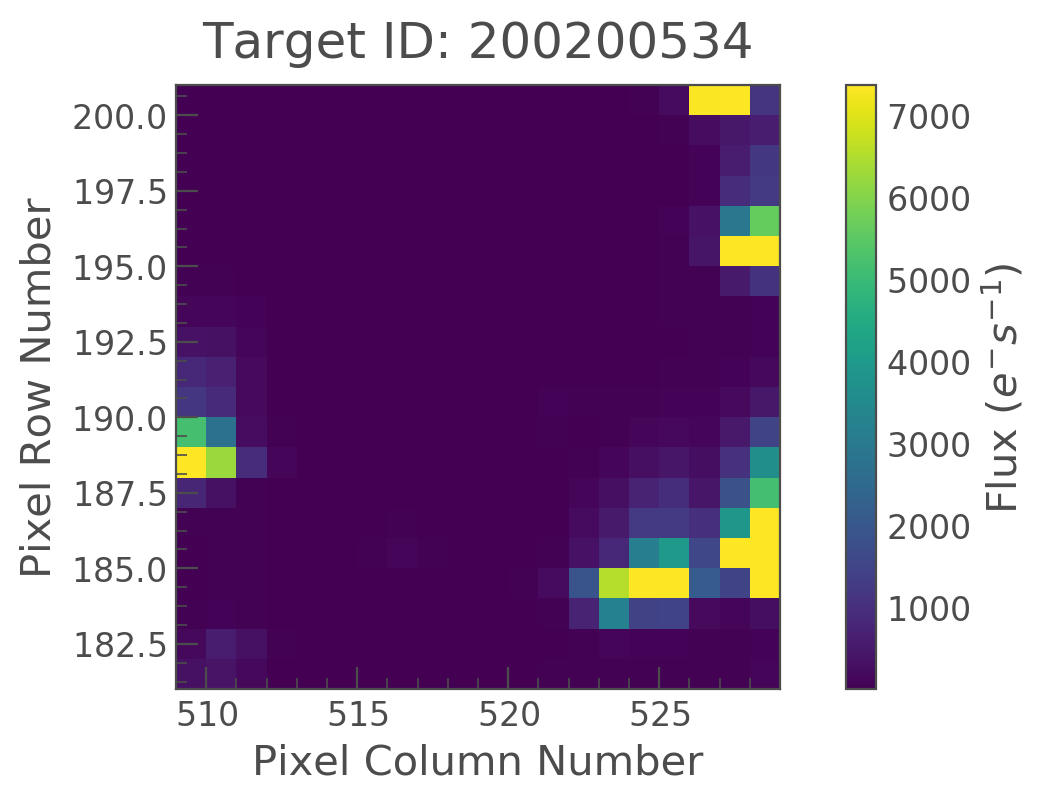

In [26]:
tpf.plot();

Oh no, which source is it??

In [27]:
delta_x, delta_y = tpf.wcs.all_world2pix(c.ra.value, c.dec.value, 1)
tpf.row + delta_x, tpf.column + delta_y

(199.91103445411747, 529.990461266046)

It's in the upper right corner.  It looks like that target protrudes onto at least one other target pixel file.

In [28]:
#tpf.interact()

Let's make a **huge data cube** of all of M67!   This takes about 3 minutes...

In [29]:
from tqdm import tqdm as tqdm

In [30]:
empty_frame = np.zeros((1024, 1024))
empty_cube = np.zeros((ncad, 1024, 1024))
for loc in tqdm(df_M67.index.values):
    tpf_local = lightkurve.KeplerTargetPixelFile(cache_dir+df_M67.fn[loc])
    x0, y0 = tpf_local.column, tpf_local.row
    ncad, dx, dy = tpf_local.shape
    empty_frame[x0:x0+dx, y0:y0+dy] = tpf_local.flux[100,:,:].T
    empty_cube[:, y0:y0+dy, x0:x0+dx] = tpf_local.flux[:,:,:]

100%|██████████| 360/360 [03:31<00:00,  1.91it/s]


In [31]:
import matplotlib.patches as patches

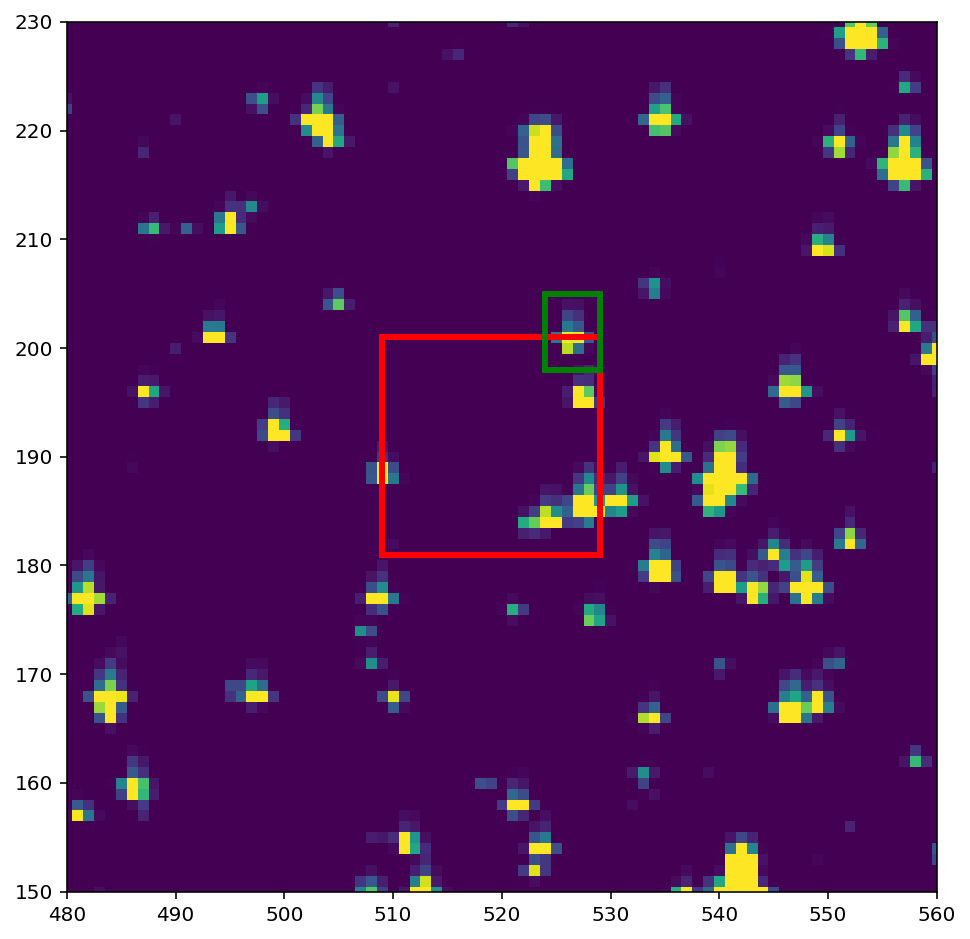

In [32]:
ax, fig = plt.subplots(1, figsize=(8,8))
frame = 400
plt.imshow(empty_cube[frame,:,:], origin='lower', vmin=500, vmax=7500)#med-0.1*sig, vmax=med+0.1*sig)
plt.xlim(520-40, 520+40)
plt.ylim(190-40, 190+40)
rect_tpf = patches.Rectangle((509,181),20,20,linewidth=3,edgecolor='r',facecolor='none')
rect_targ = patches.Rectangle((524,198),5,7,linewidth=3,edgecolor='g',facecolor='none')
plt.gca().add_patch(rect_tpf)
plt.gca().add_patch(rect_targ)

The *Red* box is the boundary of the Target Pixel File, the **Green** rectangle shows a choice for an aperture mask. Looks a lot like the pattern we saw above, so we have some assurance we've done things right!  

In [33]:
targ_cube = empty_cube[:, 199:199+8, 523:523+7]

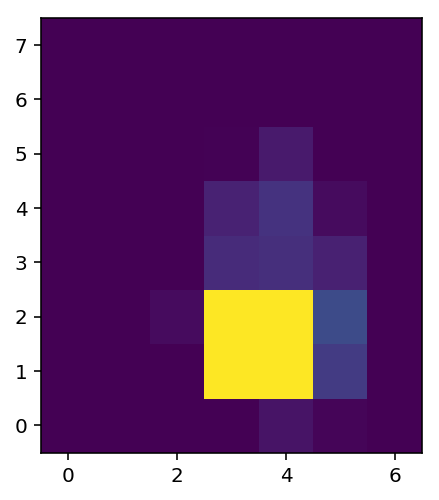

In [34]:
plt.imshow(targ_cube[3000,:,:], origin='lower', vmin=500, vmax=7500);

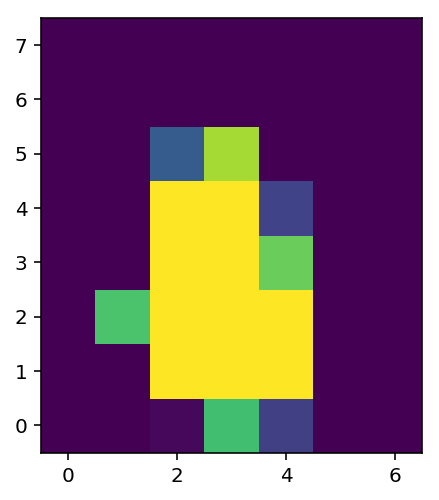

In [35]:
plt.imshow(targ_cube[3400,:,:], origin='lower', vmin=500, vmax=1000);

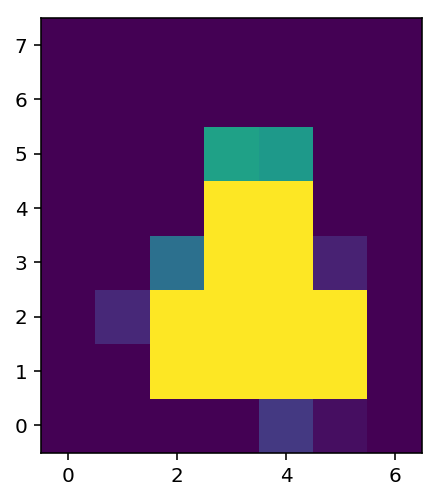

In [36]:
plt.imshow(np.nanmean(targ_cube[:,:,:], axis=0), origin='lower', vmin=500, vmax=1000);

Ok, looks like this pixel mask might work!

In [37]:
flux_out = np.nansum(targ_cube[:,:,:], axis=(1,2))

In [38]:
xcen, ycen = tpf.centroids()

/Users/obsidian/GitHub/lightkurve/lightkurve/targetpixelfile.py:481: LightkurveWarning: `TargetPixelFile.centroids()` is deprecated and will be removed in Lightkurve v1.0.0, please use `TargetPixelFile.estimate_centroids()` instead.
  LightkurveWarning)


In [39]:
lc_targ = lightkurve.KeplerLightCurve(time=tpf.time, flux=flux_out, 
                                      centroid_col=xcen, centroid_row=ycen,
                                      targetid=tpf.targetid, cadenceno=tpf.cadenceno)

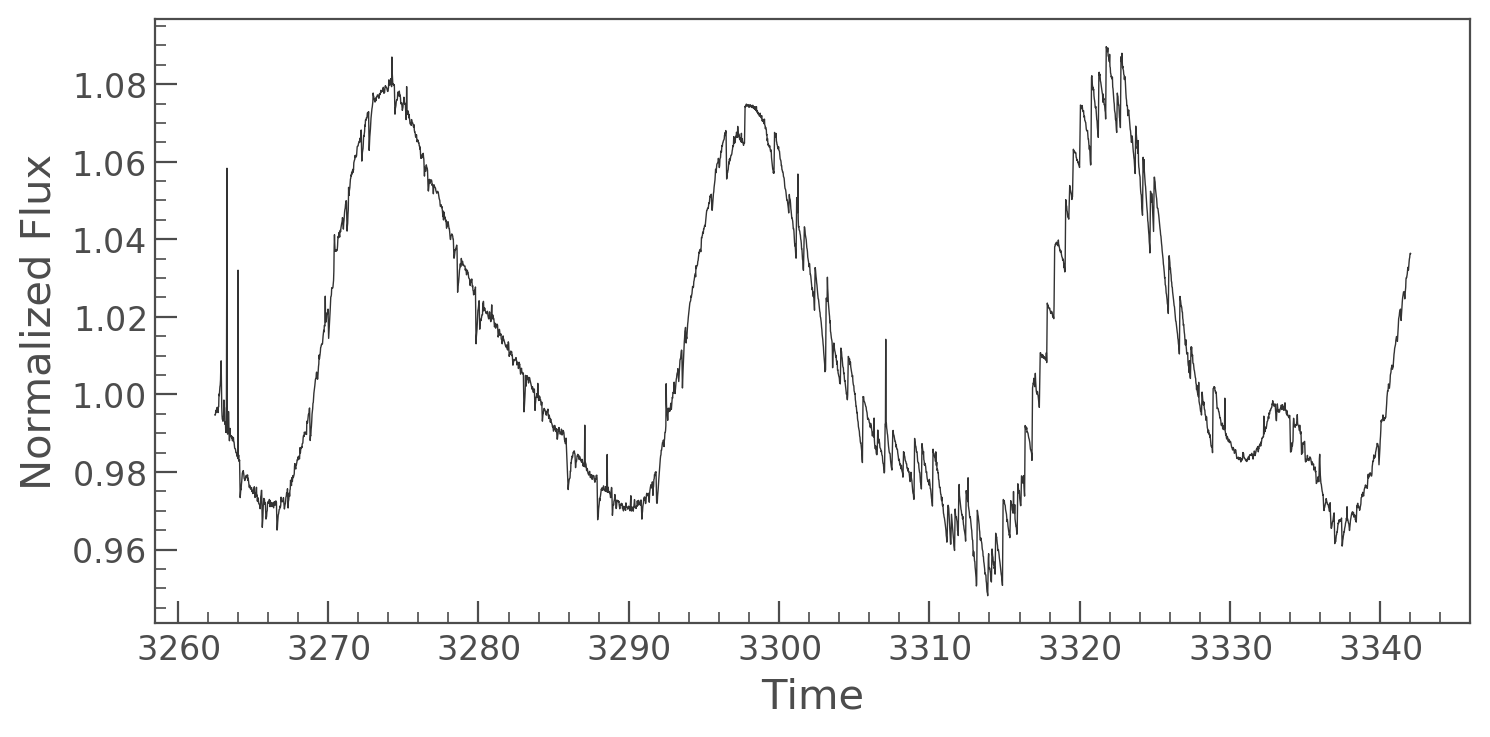

In [40]:
lc_targ.plot()

In [41]:
from lightkurve.correctors import SFFCorrector

In [42]:
sff = SFFCorrector()

In [43]:
lc_corrected = sff.correct(lc_targ.time, lc_targ.flux, 
                           lc_targ.centroid_col, lc_targ.centroid_row,
                           niters=5, windows=20, polyorder=5, restore_trend=True)

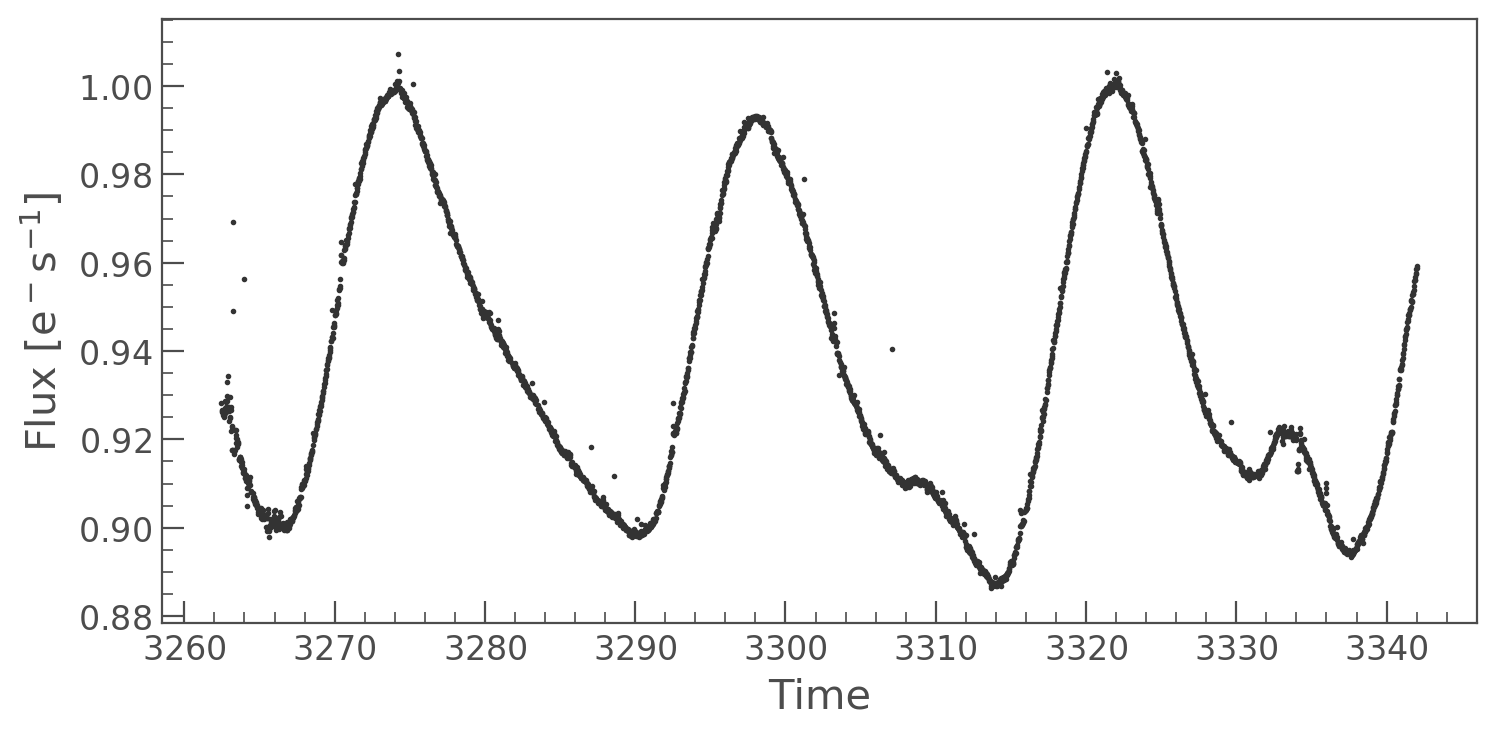

In [44]:
(lc_corrected.normalize()/1.08).scatter(normalize=False)

(2, 80)

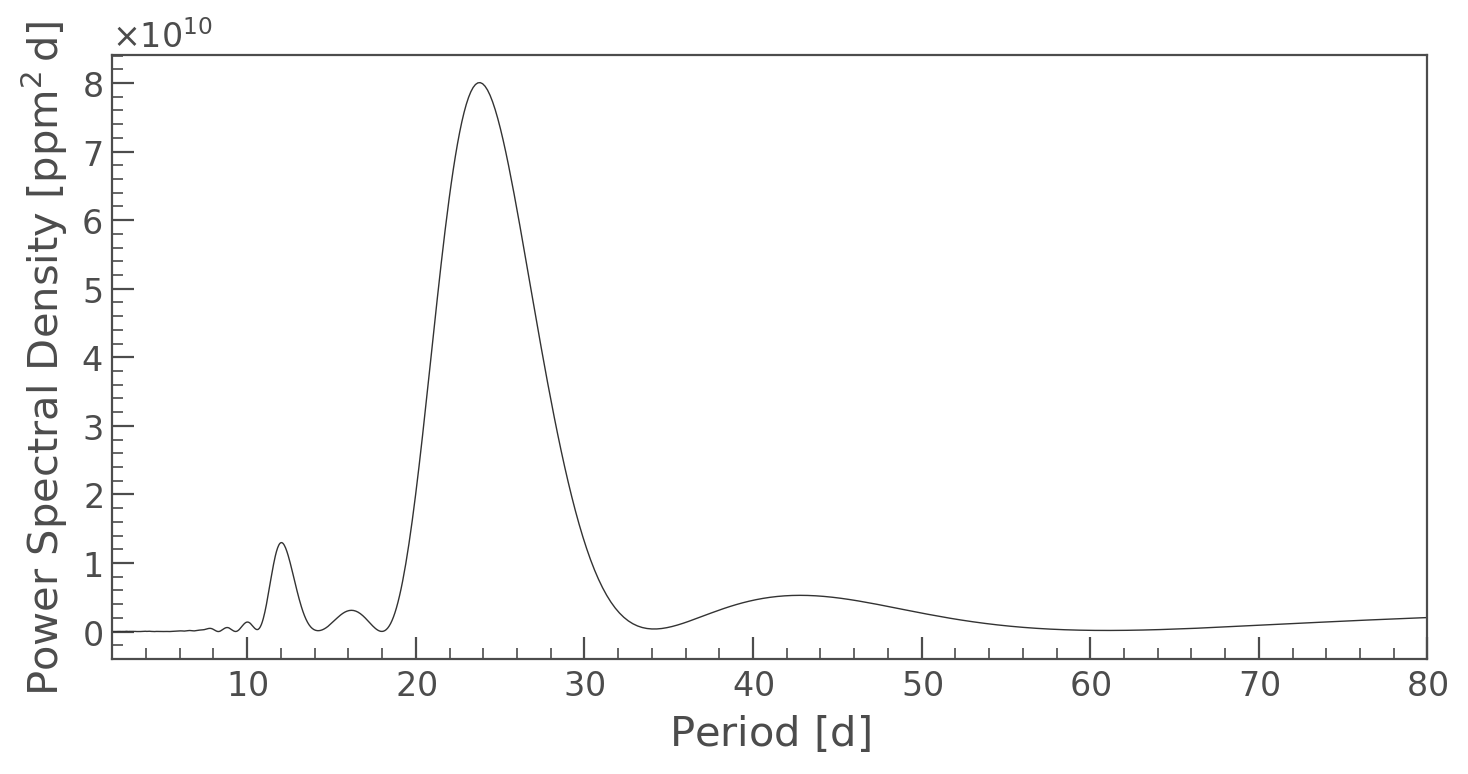

In [45]:
pg = lc_targ.to_periodogram(oversample_factor=50)
pg.plot(format='period')
plt.xlim(2, 80)

In [46]:
pg.period_at_max_power

<Quantity 23.81894153 d>

Save as a csv file.

In [47]:
df_out = lc_corrected.to_pandas()

In [48]:
df_out = df_out.reset_index(drop=True)[['time', 'flux']]
df_out.head()

,time,flux
0,3262.467428,69040.114116
1,3262.487863,68924.701273
2,3262.508299,68887.164157
3,3262.528734,68908.243668
4,3262.549170,68871.805740


In [53]:
df_out.to_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv', index=False)

Nice!